## 1 — global setup: seed, imports, deterministic backend   

In [1]:
RANDOM_SEED = 42

# ── make project root importable ────────────────────────────────
import sys
import pathlib
sys.path.append(str(pathlib.Path.cwd().parent))          # …/twitter-airline-analysis

# ── stdlib ──────────────────────────────────────────────────────
import os
import random
from pathlib import Path

# ── third-party ────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt        # used for Optuna plots later
import optuna
from joblib                           import load, dump
from sklearn import set_config
from sklearn.pipeline                 import Pipeline
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.linear_model             import LogisticRegression
from sklearn.metrics                  import roc_auc_score, classification_report, RocCurveDisplay
from sklearn.model_selection          import train_test_split

# ── local project code ─────────────────────────────────────────
from twitter_airline_analysis.data_prep import load_prepared_data

# ── global sklearn setting ─────────────────────────────────────
set_config(transform_output="pandas")

# ── project paths ──────────────────────────────────────────────
PROJECT_ROOT   = Path.cwd().resolve().parent
BASELINE_PATH  = PROJECT_ROOT / "models" / "logreg_tfidf.joblib"
TUNED_MODEL_PATH = PROJECT_ROOT / "models" / "logreg_tfidf_optuna.joblib"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
ARTIFACT_DIR  = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

# ── reproducibility ────────────────────────────────────────────
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 - load and split data

In [2]:
def _load_series(name: str):
    """Return Series from PROCESSED_DIR/<name>.ftr (or .parquet)."""
    ftr_path = PROCESSED_DIR / f"{name}.ftr"
    pq_path  = PROCESSED_DIR / f"{name}.parquet"

    if ftr_path.exists():
        df = pd.read_feather(ftr_path)
    elif pq_path.exists():
        df = pd.read_parquet(pq_path)
    else:
        raise FileNotFoundError(
            f"Neither {ftr_path.name} nor {pq_path.name} found in {PROCESSED_DIR}"
        )

    if df.shape[1] == 1:
        return df.iloc[:, 0]                  # take the sole column, whatever its name
    elif name in df.columns:
        return df[name]                       # column matches expected name
    else:
        raise KeyError(
            f"Expected column '{name}' not found in {ftr_path.name}. "
            f"Columns present: {list(df.columns)}"
        )

# X, y splits already materialised during Module‑4
X_train = _load_series("X_train")
X_valid = _load_series("X_val")
X_test  = _load_series("X_test")

y_train = _load_series("y_train")
y_valid = _load_series("y_val")
y_test  = _load_series("y_test")

print(
    "Shapes —",
    f"train: {X_train.shape},  valid: {X_valid.shape},  test: {X_test.shape}"
)


Shapes — train: (11712,),  valid: (1464,),  test: (1464,)


## 3 - Baseline Reference (Pre‑Optuna)      

In [3]:
"""
Falls back to training a minimal model
if the file isn’t found, so the notebook remains runnable end-to-end.
"""

print(f"Looking for baseline at: {BASELINE_PATH}")

if BASELINE_PATH.exists():
    baseline_pipe = load(BASELINE_PATH)
    print("✔ Loaded baseline artefact.")
else:
    print("✗ Baseline artefact not found – training quick default model...")
    baseline_pipe = Pipeline([
        ("tfidf", TfidfVectorizer(sublinear_tf=True)),
        ("clf",   LogisticRegression(max_iter=500, n_jobs=-1, random_state=42)),
    ])
    baseline_pipe.fit(X_train, y_train)
    BASELINE_PATH.parent.mkdir(exist_ok=True)
    dump(baseline_pipe, BASELINE_PATH)
    print(f"Saved new baseline to {BASELINE_PATH}")

# ── validation metric ──────────────────────────────────────────
baseline_preds = baseline_pipe.predict_proba(X_valid)      # ← NO slicing
baseline_auc   = roc_auc_score(
    y_valid,
    baseline_preds,
    multi_class="ovr",
    average="weighted",
)


print(f"Baseline TF‑IDF + LogReg AUC (OVR, weighted): {baseline_auc:.3f}")



Looking for baseline at: C:\Projects\twitter-airline-analysis\models\logreg_tfidf.joblib
✔ Loaded baseline artefact.
Baseline TF‑IDF + LogReg AUC (OVR, weighted): 0.968


## 3 - Optuna Setup

The objective is deliberately lightweight; feature engineering is confined to TfidfVectorizer to keep search time reasonable.

In [4]:
def objective(trial: optuna.Trial) -> float:
    """Return validation ROC-AUC for a single Optuna trial."""
    # ── pipeline definition ─────────────────────────────────────
    pipeline = Pipeline([
        (
            "tfidf",
            TfidfVectorizer(
                max_df      = trial.suggest_float("max_df", 0.7, 1.0),
                min_df      = trial.suggest_int("min_df", 1, 10),
                ngram_range = (1, trial.suggest_int("max_ngram", 1, 3)),
                sublinear_tf=True,
            ),
        ),
        (
            "clf",
            LogisticRegression(
                C        = trial.suggest_loguniform("C", 1e-3, 1e2),
                penalty  = trial.suggest_categorical("penalty", ["l2", "elasticnet"]),
                solver   = "saga",
                l1_ratio = (
                    trial.suggest_float("l1_ratio", 0.0, 1.0)
                    if trial.params.get("penalty") == "elasticnet"
                    else None
                ),
                max_iter     = 500,
                n_jobs       = -1,
                random_state = RANDOM_SEED,
            ),
        ),
    ])

    pipeline.fit(X_train, y_train)
    probs  = pipeline.predict_proba(X_valid)
    score  = roc_auc_score(y_valid, probs, multi_class="ovr", average="weighted")

    # ---- persist model & store path (JSON‑friendly) ------------
    model_path = ARTIFACT_DIR / f"trial_{trial.number}_pipe.joblib"
    dump(pipeline, model_path)
    trial.set_user_attr("pipeline_path", str(model_path))     # <- string, not object
    return score

# ── create / load study ────────────────────────────────────────
study = optuna.create_study(
    direction      = "maximize",
    study_name     = "logreg_tfidf_auc",
    pruner         = optuna.pruners.MedianPruner(n_warmup_steps=10),
    storage        = f"sqlite:///{ARTIFACT_DIR/'optuna_study.db'}",
    load_if_exists = True,
)

[I 2025-08-04 15:00:04,713] Using an existing study with name 'logreg_tfidf_auc' instead of creating a new one.


## 4 - Run Study

In [5]:
study.optimize(objective, n_trials=20, show_progress_bar=True)

best_path     = Path(study.best_trial.user_attrs["pipeline_path"])
best_pipeline = load(best_path)
print(f"✅ Best pipeline loaded from {best_path}")

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),
Best trial: 12. Best value: 0.910794:   5%|▌         | 1/20 [00:01<00:20,  1.10s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:00:05,807] Trial 23 finished with value: 0.9085720436413247 and parameters: {'max_df': 0.8620203743946748, 'min_df': 2, 'max_ngram': 2, 'C': 0.6718059487737534, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  10%|█         | 2/20 [00:02<00:19,  1.10s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:00:06,925] Trial 24 finished with value: 0.9074338151013048 and parameters: {'max_df': 0.8690788263171235, 'min_df': 2, 'max_ngram': 2, 'C': 0.5582615276353687, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  15%|█▌        | 3/20 [00:03<00:21,  1.27s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:00:08,397] Trial 25 finished with value: 0.8939151657313174 and parameters: {'max_df': 0.8089172015913628, 'min_df': 2, 'max_ngram': 3, 'C': 0.12704784583614398, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  20%|██        | 4/20 [00:04<00:19,  1.22s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:00:09,541] Trial 26 finished with value: 0.9085413742631853 and parameters: {'max_df': 0.9200877225789492, 'min_df': 4, 'max_ngram': 2, 'C': 4.783659169948866, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  25%|██▌       | 5/20 [00:05<00:15,  1.02s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:00:10,207] Trial 27 finished with value: 0.9069662198649704 and parameters: {'max_df': 0.9595600105965643, 'min_df': 1, 'max_ngram': 1, 'C': 0.9941680597933485, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  30%|███       | 6/20 [00:06<00:16,  1.15s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:00:11,600] Trial 28 finished with value: 0.8986575753121628 and parameters: {'max_df': 0.8365173485744298, 'min_df': 3, 'max_ngram': 3, 'C': 0.18195274490667737, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Best trial: 12. Best value: 0.910794:  35%|███▌      | 7/20 [01:25<05:43, 26.42s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:01:30,054] Trial 29 finished with value: 0.9040453756628447 and parameters: {'max_df': 0.7766900713606031, 'min_df': 2, 'max_ngram': 2, 'C': 3.9783374130737426, 'penalty': 'elasticnet', 'l1_ratio': 0.992434932013782}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  40%|████      | 8/20 [01:26<03:41, 18.44s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:01:31,376] Trial 30 finished with value: 0.9106251193928486 and parameters: {'max_df': 0.9144181325923053, 'min_df': 4, 'max_ngram': 3, 'C': 1.0495245487458773, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  45%|████▌     | 9/20 [01:28<02:27, 13.38s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:01:33,667] Trial 31 finished with value: 0.8871509246526257 and parameters: {'max_df': 0.9791307406308765, 'min_df': 5, 'max_ngram': 3, 'C': 36.26550844222644, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  50%|█████     | 10/20 [02:28<04:36, 27.65s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:33,260] Trial 32 finished with value: 0.8992823174251554 and parameters: {'max_df': 0.9233283599898546, 'min_df': 4, 'max_ngram': 3, 'C': 8.26012305655648, 'penalty': 'elasticnet', 'l1_ratio': 0.6939163520650208}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  55%|█████▌    | 11/20 [02:29<02:56, 19.56s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:34,493] Trial 33 finished with value: 0.9071938115823657 and parameters: {'max_df': 0.8233389818482992, 'min_df': 7, 'max_ngram': 3, 'C': 1.7402233524595467, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  60%|██████    | 12/20 [02:30<01:51, 13.94s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:35,544] Trial 34 finished with value: 0.9089411574566096 and parameters: {'max_df': 0.8740826775636207, 'min_df': 3, 'max_ngram': 2, 'C': 0.703210607712619, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  65%|██████▌   | 13/20 [02:31<01:10, 10.02s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:36,580] Trial 35 finished with value: 0.8833194385641376 and parameters: {'max_df': 0.9043495008947361, 'min_df': 3, 'max_ngram': 2, 'C': 0.04703750694464324, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  70%|███████   | 14/20 [02:33<00:44,  7.37s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:37,806] Trial 36 finished with value: 0.9057759667007357 and parameters: {'max_df': 0.8773961327848064, 'min_df': 4, 'max_ngram': 3, 'C': 0.37801161710878484, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  75%|███████▌  | 15/20 [02:49<00:50, 10.05s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:54,073] Trial 37 finished with value: 0.9088414748349254 and parameters: {'max_df': 0.9001779778894372, 'min_df': 5, 'max_ngram': 2, 'C': 2.671378382437238, 'penalty': 'elasticnet', 'l1_ratio': 0.8424772088551504}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  80%|████████  | 16/20 [02:50<00:29,  7.34s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:55,121] Trial 38 finished with value: 0.8893047586252788 and parameters: {'max_df': 0.9418555911660603, 'min_df': 3, 'max_ngram': 2, 'C': 0.07721974388156466, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  85%|████████▌ | 17/20 [02:53<00:18,  6.19s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:02:58,654] Trial 39 finished with value: 0.9019293557911159 and parameters: {'max_df': 0.9682003695806424, 'min_df': 4, 'max_ngram': 1, 'C': 1.0047555795742418, 'penalty': 'elasticnet', 'l1_ratio': 0.44002044031921456}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  90%|█████████ | 18/20 [02:55<00:09,  4.77s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:03:00,127] Trial 40 finished with value: 0.9053524729661518 and parameters: {'max_df': 0.9143371867938618, 'min_df': 3, 'max_ngram': 3, 'C': 7.694538118638148, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


Best trial: 12. Best value: 0.910794:  95%|█████████▌| 19/20 [02:56<00:03,  3.64s/it]C:\Users\justi\AppData\Local\Temp\ipykernel_8800\1446669926.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C        = trial.suggest_loguniform("C", 1e-3, 1e2),


[I 2025-08-04 15:03:01,117] Trial 41 finished with value: 0.9031470734179899 and parameters: {'max_df': 0.8834184207107105, 'min_df': 5, 'max_ngram': 2, 'C': 0.23984653398909128, 'penalty': 'l2'}. Best is trial 12 with value: 0.9107937658707393.


c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Best trial: 12. Best value: 0.910794: 100%|██████████| 20/20 [04:47<00:00, 14.38s/it]


[I 2025-08-04 15:04:52,302] Trial 42 finished with value: 0.8703748310058508 and parameters: {'max_df': 0.9373500203977988, 'min_df': 6, 'max_ngram': 3, 'C': 25.714453314822407, 'penalty': 'elasticnet', 'l1_ratio': 0.9934468584742072}. Best is trial 12 with value: 0.9107937658707393.
✅ Best pipeline loaded from C:\Projects\twitter-airline-analysis\artifacts\trial_12_pipe.joblib


## 4 -  Persist & reload the best model

In [6]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ 4 – Persist & reload the best model                          ║
# ╚══════════════════════════════════════════════════════════════╝
# 1. Locate the file written inside the objective
best_path = Path(study.best_trial.user_attrs["pipeline_path"])
print(f"✅  Best pipeline located at {best_path}")

# 2. Load it
best_pipeline = load(best_path)

# 3. Save a canonical copy in models/ for later notebooks
TUNED_MODEL_PATH.parent.mkdir(exist_ok=True)
dump(best_pipeline, TUNED_MODEL_PATH)
print(f"🔒  Saved tuned model → {TUNED_MODEL_PATH}")

# 4. (optional sanity check)
assert hasattr(best_pipeline, "predict_proba")


✅  Best pipeline located at C:\Projects\twitter-airline-analysis\artifacts\trial_12_pipe.joblib
🔒  Saved tuned model → C:\Projects\twitter-airline-analysis\models\logreg_tfidf_optuna.joblib


## 5 - Final evaluation on the held‑out test set

              precision    recall  f1-score   support

    negative      0.819     0.950     0.879       918
     neutral      0.751     0.574     0.651       310
    positive      0.821     0.564     0.668       236

    accuracy                          0.808      1464
   macro avg      0.797     0.696     0.733      1464
weighted avg      0.805     0.808     0.797      1464

Weighted OVR ROC‑AUC: 0.913


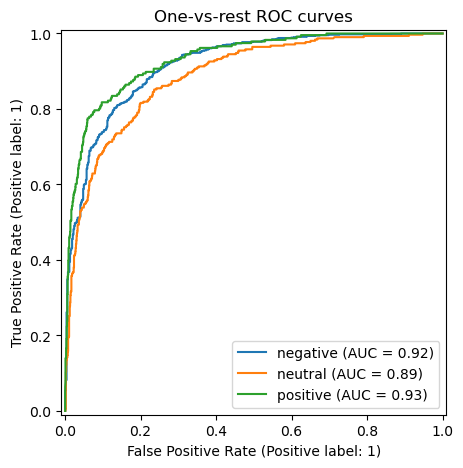

In [7]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ 5 – Final evaluation on the held‑out test set                ║
# ╚══════════════════════════════════════════════════════════════╝
# 1. Discrete predictions for class‑level metrics
y_pred = best_pipeline.predict(X_test)         # → array of strings

from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

print(classification_report(y_test, y_pred, digits=3))

# 2. Probabilities for ROC‑AUC
probs = best_pipeline.predict_proba(X_test)    # shape (n_samples, 3)

auc  = roc_auc_score(
    y_test,
    probs,
    multi_class="ovr",
    average="weighted",
)
print(f"Weighted OVR ROC‑AUC: {auc:.3f}")

# 3. Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 5))

classes = best_pipeline.classes_           # ['negative', 'neutral', 'positive']
y_bin   = label_binarize(y_test, classes=classes)  # shape (n_samples, 3)

for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_bin[:, i],
        probs[:, i],
        name=cls,
        ax=ax,
    )

ax.set_title("One‑vs‑rest ROC curves")
plt.show()



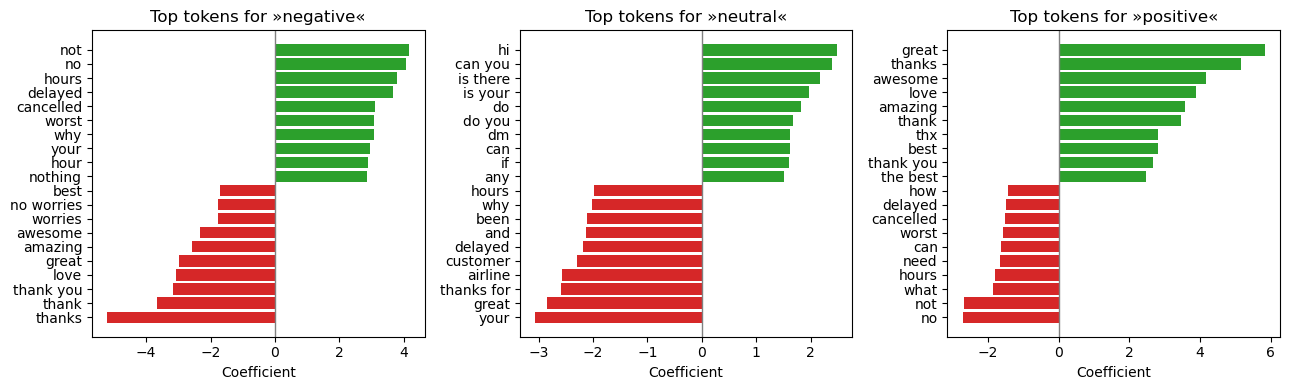

In [8]:
# %% ━━━━━━━━━━━━━━━━━━━  Token‑level importance (top coefficients) ━━━━━━━━━━━━━━━━━━━
import numpy as np
import matplotlib.pyplot as plt

vectorizer = best_pipeline.named_steps["tfidf"]
clf        = best_pipeline.named_steps["clf"]

classes     = clf.classes_                    # ['negative', 'neutral', 'positive']
feature_ix  = np.argsort            # handy alias

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=False)

for i, cls in enumerate(classes):
    coefs   = clf.coef_[i]                   # 1‑vs‑rest weights
    top_pos = feature_ix(coefs)[-10:]        # 10 most positive tokens
    top_neg = feature_ix(coefs)[:10]         # 10 most negative tokens
    top_ix  = np.concatenate([top_neg, top_pos])
    tokens  = np.array(vectorizer.get_feature_names_out())[top_ix]
    weights = coefs[top_ix]

    axes[i].barh(tokens, weights, color=["tab:red"]*10 + ["tab:green"]*10)
    axes[i].axvline(0, color="grey", lw=1)
    axes[i].set_title(f"Top tokens for »{cls}«")
    axes[i].set_xlabel("Coefficient")

plt.tight_layout()
plt.show()


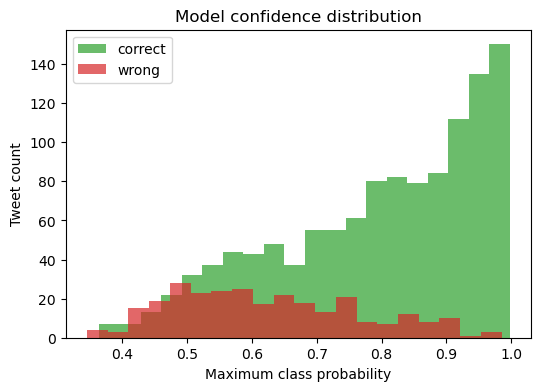

In [9]:
# %% ━━━━━━━━━━━━━━━━━━━  Confidence histogram (correct vs. wrong) ━━━━━━━━━━━━━━━━━━━
import matplotlib.pyplot as plt

# highest predicted probability for each sample
conf = probs.max(axis=1)
correct = (y_pred == y_test)

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(conf[correct], bins=20, alpha=0.7, label="correct", color="tab:green")
ax.hist(conf[~correct], bins=20, alpha=0.7, label="wrong",   color="tab:red")
ax.set_xlabel("Maximum class probability")
ax.set_ylabel("Tweet count")
ax.set_title("Model confidence distribution")
ax.legend()
plt.show()


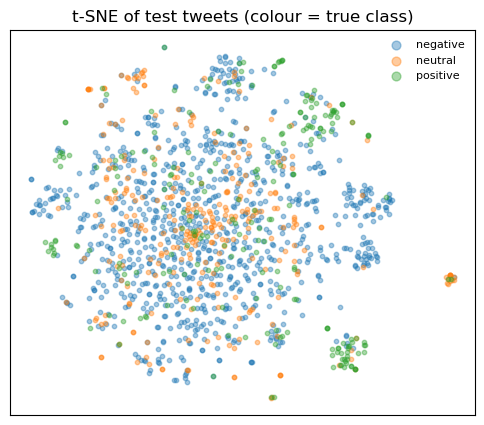

In [14]:
# %% — t‑SNE embedding coloured by true class (bullet‑proof)
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Dense 50‑D representation  ➜  2‑D t‑SNE -------------------------------
X_dense = TruncatedSVD(n_components=50, random_state=42).fit_transform(
    vectorizer.transform(X_test)
)
emb = TSNE(
    n_components=2,
    init="pca",
    perplexity=30,
    random_state=42,
).fit_transform(X_dense)

emb = np.asarray(emb)          # ← guarantee plain ndarray (critical!)

# 2. Labels & classes -------------------------------------------------------
labels  = np.asarray(y_test)   # strips index
classes = best_pipeline.classes_

# 3. Scatter plot -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

for cls in classes:
    mask = labels == cls       # boolean ndarray
    ax.scatter(
        emb[mask, 0],
        emb[mask, 1],
        s=10,
        alpha=0.4,
        label=cls,
    )

ax.set_xticks([]); ax.set_yticks([])
ax.set_title("t‑SNE of test tweets (colour = true class)")
ax.legend(markerscale=2, fontsize=8, frameon=False)
plt.show()


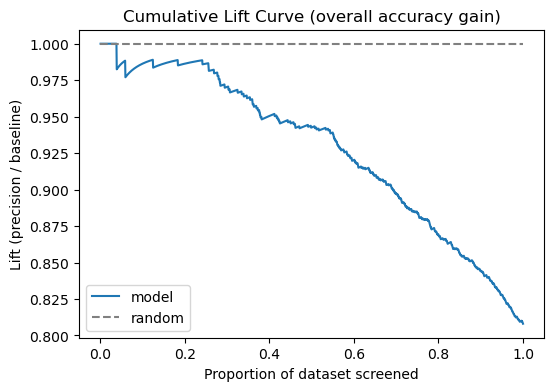

In [15]:
# %% ━━━━━━━━━━━━━━━━━━━  Lift / Cumulative gains curve (macro‑average) ━━━━━━━━━━━━━━
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# macro‑average lift: sort by max prob descending
order = np.argsort(-probs.max(axis=1))
cum_hits, cum_total = [], []
n_samples = len(y_test)

# convert labels to binary "correct prediction"
is_hit = (y_pred == y_test).astype(int)[order]

for i in range(1, n_samples + 1):
    cum_hits.append(is_hit[:i].sum())
    cum_total.append(i)

lift = np.array(cum_hits) / np.arange(1, n_samples + 1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(1, n_samples + 1) / n_samples, lift, label="model")
ax.plot([0, 1], [1, 1], "--", color="grey", label="random")
ax.set_xlabel("Proportion of dataset screened")
ax.set_ylabel("Lift (precision / baseline)")
ax.set_title("Cumulative Lift Curve (overall accuracy gain)")
ax.legend()
plt.show()


## 6 - Persist artefacts